In [10]:
### these should go easy
import sys
import pandas as pd
import numpy as np
import os
import string
import collections

import nltk
from nltk.collocations import *

### for network analysis
import networkx as nx

### our own package for generating and visualizing networks
import network_functions as nf

### for visualization
import plotly.plotly as py
import plotly.graph_objs as go
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
init_notebook_mode(connected=True)

In [5]:
projevy_df = pd.read_pickle("projevy_lemmatized_df.pickle")

In [6]:
projevy_df.head(5)

rok_prezident                                               text  \
0    1935-Benes   Státy se udrží ideami, jimiž vznikly, řekl pr...   
1    1936-Benes   Drazí spoluobčané! Prožili jsme velmi pohnutý...   
2    1937-Benes   Drazí spoluobčané! Konče loni svůj vánoční pr...   
3    1938-Hacha                                                      
4    1939-Hacha   Drazí občané českých zemí, bratři a sestry!  ...   

                                    lemmata_filtered  
0  [stát, idea, prezident, osvoboditel, g, masary...  
1  [drahý, spoluobčan, pohnutý, rok, pohnutý, rok...  
2  [drahý, spoluobčan, vánoční, projev, rozhlas, ...  
3                                                 []  
4  [drahý, občan, český, země, bratr, sestra, ště...

In [21]:
### find the most common terms:
# (a) choose 50 most frequent words from each speech and put them into one list
# (b) choose 30 most frequent terms in this list
interesting_terms_candidates = []
for projev in projevy_df["lemmata_filtered"].tolist():
    interesting_terms_candidates.extend([word_tuple[0] for word_tuple in nltk.FreqDist(projev).most_common(50)])
interesting_terms_tuples =nltk.FreqDist(interesting_terms_candidates).most_common(30)
interesting_terms = [word_tuple[0] for word_tuple in interesting_terms_tuples]
print(interesting_terms)

['rok', 'nový', 'dobrý', 'země', 'život', 'stát', 'člověk', 'práce', 'velký', 'celý', 'svět', 'další', 'strana', 'republika', 'sovětský', 'společnost', 'politický', 'národní', 'občan', 'lid', 'socialistický', 'národ', 'svaz', 'každý', 'úkol', 'rozvoj', 'mír', 'síla', 'politika', 'spoluobčan']


In [ ]:
president_names = ["Benes", "Gottwald", "Zapotocky", "Novotny", "Svoboda", "Husak", "Havel", "Klaus", "Zeman"]

In [29]:
def network_formation_df(data_frame, prezident, lexicon_size, threshold):
    '''From a dataframe with rows corresponding to individual documents,
    to be subsellected on the basis of author's name column, for instance'''
    lemmata_list = []
    ### for each year's speech:
    for element in data_frame[data_frame["rok_prezident"].str.endswith(prezident)]["lemmata_filtered"].tolist():        
        lemmata_list.extend(element)
    lexicon = [word_tuple[0] for word_tuple in nltk.FreqDist(lemmata_list).most_common(lexicon_size)]
    bigrams_list = []
    for element in data_frame[data_frame["rok_prezident"].str.endswith(prezident)]["lemmata_filtered"].tolist():
        lemmatized_text = element
        for bigram in nltk.bigrams(lemmatized_text):
            if ((bigram[0] in lexicon) & (bigram[1] in lexicon)):
                if bigram[0] != bigram[1]:
                    bigrams_list.append(tuple(sorted(bigram)))
    bigrams_counts = list((collections.Counter(bigrams_list)).items())
    bigrams_counts = sorted(bigrams_counts, key=lambda x: x[1], reverse=True)
    ### create a NetworkX object
    G = nx.Graph()
    G.clear()
    ### form the network from tuples of this form: (node1, node2, number of co-occurrences / lenght of the document)
    G.add_weighted_edges_from(np.array([(bigram_count[0][0], bigram_count[0][1],  int(bigram_count[1])) for bigram_count in bigrams_counts if bigram_count[1] >= threshold]))
    ### add distance attribute
    for (u, v, wt) in G.edges.data('weight'):
        G.add_edge(u,v,distance=round(1/ int(wt), 5))
    document_lenght = len(lemmata_list)
    for (u, v, wt) in G.edges.data('weight'):
        G.add_edge(u,v,norm_weight=round(int(wt)/document_lenght, 5))
    return G
def ego_network_drawing_reduced(network, term, num_of_neighbours, title, mode):
    '''derrive ego network from a preexisting network
    specify source term and number of neighbors
    includes only shortest paths from the source'''
    length, path = nx.single_source_dijkstra(network, term, target=None, weight="distance")
    shortest_nodes = list(length.keys())[0:num_of_neighbours+1]
    path_values_sorted = [dict_pair[1] for dict_pair in sorted(path.items(), key=lambda pair: list(length.keys()).index(pair[0]))]
    path_edges = []
    for path_to_term in path_values_sorted[1:num_of_neighbours+1]:
        path_edges.extend([tuple(sorted(bigram)) for bigram in nltk.bigrams(path_to_term)])
    shortest_edges = list(set(path_edges))
    ego_network = network.copy(as_view=False)
    nodes_to_remove = []
    for node in ego_network.nodes:
        if node not in shortest_nodes:
            nodes_to_remove.append(node)
    for element in nodes_to_remove:
        ego_network.remove_node(element)    
    edges_to_remove = []
    for edge in ego_network.edges:
        if edge not in shortest_edges:
            if (edge[1],edge[0]) not in shortest_edges:
                edges_to_remove.append(edge)
    for element in edges_to_remove:
        ego_network.remove_edge(element[0], element[1])
    return draw_3d_network(ego_network, title, mode)

def draw_3d_network(networkx_object, file_name, mode):
    '''take networkX object and draw it in 3D'''
    Edges = list(networkx_object.edges)
    L=len(Edges)
    distance_list = [distance[2] for distance in list(networkx_object.edges.data("distance"))]
    weight_list = [int(float(weight[2])) for weight in list(networkx_object.edges.data("weight"))]
    labels= list(networkx_object.nodes)
    N = len(labels)
    adjc= [len(one_adjc) for one_adjc in list((nx.generate_adjlist(networkx_object)))] ### instead of "group"
    pos_3d=nx.spring_layout(networkx_object, weight="weight", dim=3)
    nx.set_node_attributes(networkx_object, pos_3d, "pos_3d")
    layt = [list(array) for array in pos_3d.values()]
    N= len(networkx_object.nodes)
    Xn=[layt[k][0] for k in range(N)]# x-coordinates of nodes
    Yn=[layt[k][1] for k in range(N)]# y-coordinates
    Zn=[layt[k][2] for k in range(N)]# z-coordinates
    Xe=[]
    Ye=[]
    Ze=[]
    for Edge in Edges:
        Xe+=[networkx_object.nodes[Edge[0]]["pos_3d"][0],networkx_object.nodes[Edge[1]]["pos_3d"][0], None]# x-coordinates of edge ends
        Ye+=[networkx_object.nodes[Edge[0]]["pos_3d"][1],networkx_object.nodes[Edge[1]]["pos_3d"][1], None]
        Ze+=[networkx_object.nodes[Edge[0]]["pos_3d"][2],networkx_object.nodes[Edge[1]]["pos_3d"][2], None]

        ### to get the hover into the middle of the line
        ### we have to produce a node in the middle of the line
        ### based on https://stackoverflow.com/questions/46037897/line-hover-text-in-plotly

    middle_node_trace = go.Scatter3d(
            x=[],
            y=[],
            z=[],
            opacity=0,
            text=weight_list,
            mode='markers',
            hoverinfo='text',
            marker=dict(
                opacity=0
            )
        )

    for Edge in Edges:

        x0,y0,z0 = networkx_object.nodes[Edge[0]]["pos_3d"]
        x1,y1,z1 = networkx_object.nodes[Edge[1]]["pos_3d"]
        ###trace3['x'] += [x0, x1, None]
        ###trace3['y'] += [y0, y1, None]
        ###trace3['z'] += [z0, z1, None]
        ###trace3_list.append(trace3)
        middle_node_trace['x'] += tuple([(x0+x1)/2])
        middle_node_trace['y'] += tuple([(y0+y1)/2])#.append((y0+y1)/2)
        middle_node_trace['z'] += tuple([(z0+z1)/2])#.append((z0+z1)/2)
        

    ### edge trace    
    edge_trace1 = go.Scatter3d(
        x=[], y=[], z=[],
        #hoverinfo='none',
        mode='lines',
        line=dict(width=0.8,color="#000000"),
        )
    edge_trace2 = go.Scatter3d(
        x=[],y=[], z=[],
        #hoverinfo='none',
        mode='lines',
        line=dict(width=0.5,color="#404040"),
        )
    edge_trace3 = go.Scatter3d(
        x=[], y=[], z=[],
        #hoverinfo='none',
        mode='lines',
        line=dict(width=0.3,color="#C0C0C0"),
        )
    best_5percent_norm_weight = sorted(list(networkx_object.edges.data("norm_weight")), key=lambda x: x[2], reverse=True)[int((len(networkx_object.edges.data("norm_weight")) / 100) * 5)][2]
    best_20percent_norm_weight = sorted(list(networkx_object.edges.data("norm_weight")), key=lambda x: x[2], reverse=True)[int((len(networkx_object.edges.data("norm_weight")) / 100) * 20)][2]
    for edge in networkx_object.edges.data():
        if edge[2]["norm_weight"] >= best_5percent_norm_weight:
            x0, y0, z0 = networkx_object.node[edge[0]]['pos_3d']
            x1, y1, z1 = networkx_object.node[edge[1]]['pos_3d']
            edge_trace1['x'] += tuple([x0, x1, None])
            edge_trace1['y'] += tuple([y0, y1, None])
            edge_trace1['z'] += tuple([z0, z1, None])
        else:
            if edge[2]["norm_weight"] >= best_20percent_norm_weight:
                x0, y0, z0 = networkx_object.node[edge[0]]['pos_3d']
                x1, y1, z1 = networkx_object.node[edge[1]]['pos_3d']
                edge_trace1['x'] += tuple([x0, x1, None])
                edge_trace1['y'] += tuple([y0, y1, None])
                edge_trace1['z'] += tuple([z0, z1, None])
            else:
                x0, y0, z0 = networkx_object.node[edge[0]]['pos_3d']
                x1, y1, z1 = networkx_object.node[edge[1]]['pos_3d']
                edge_trace1['x'] += tuple([x0, x1, None])
                edge_trace1['y'] += tuple([y0, y1, None])
                edge_trace1['z'] += tuple([z0, z1, None])
    

    ### node trace
    node_trace=go.Scatter3d(x=Xn,
                       y=Yn,
                       z=Zn,
                       mode='markers+text',
                       ###name=labels,
                       marker=dict(symbol='circle',
                                     size=6,
                                     color=adjc,
                                     colorscale='Earth',
                                     reversescale=True,
                                     line=dict(color='rgb(50,50,50)', width=0.5)
                                     ),
                       text=[],
                       #textposition='bottom center',
                       #hovertext=adjc,
                       #hoverinfo='text'
                       )
    for node in networkx_object.nodes():
        node_trace["text"] += tuple([node])
    
    axis=dict(showbackground=False,
                  showline=False,
                  zeroline=False,
                  showgrid=False,
                  showticklabels=False,
                  title=''
                  )
    layout = go.Layout(
                 title="",
                 width=1200,
                 height=800,
                 showlegend=False,
                 scene=dict(
                     xaxis=dict(axis),
                     yaxis=dict(axis),
                     zaxis=dict(axis),
                ),
             margin=dict(
                t=100
            ),
            hovermode='closest',
            annotations=[
                   dict(
                   showarrow=False,
                    text="",
                    xref='paper',
                    yref='paper',
                    x=0,
                    y=0.1,
                    xanchor='left',
                    yanchor='bottom',
                    font=dict(
                    size=14
                    )
                    )
                ],    )
    data=[edge_trace1, edge_trace2, edge_trace3, node_trace, middle_node_trace]
    fig=go.Figure(data=data, layout=layout)
    if mode=="offline":
        return plot(fig, filename="../" + file_name+"_3D.html")
    if mode=="online":
        return py.iplot(fig, filename=file_name)
    if mode=="eps":
        return pio.write_image(fig, "../" + file_name + "_3D.eps" , scale=1)
def ego_network_standard(prezident_name, term):
    network = network_formation_df(projevy_df, prezident_name, 200, 1)
    ego_network_drawing_reduced(network, term, 30, prezident_name + " - " + term, "offline")

In [33]:
def ego_network_standard(prezident_name, term):
    network = network_formation_df(projevy_df, prezident_name, 200, 1)
    ego_network_drawing_reduced(network, term, 30, prezident_name + " - " + term, "offline")

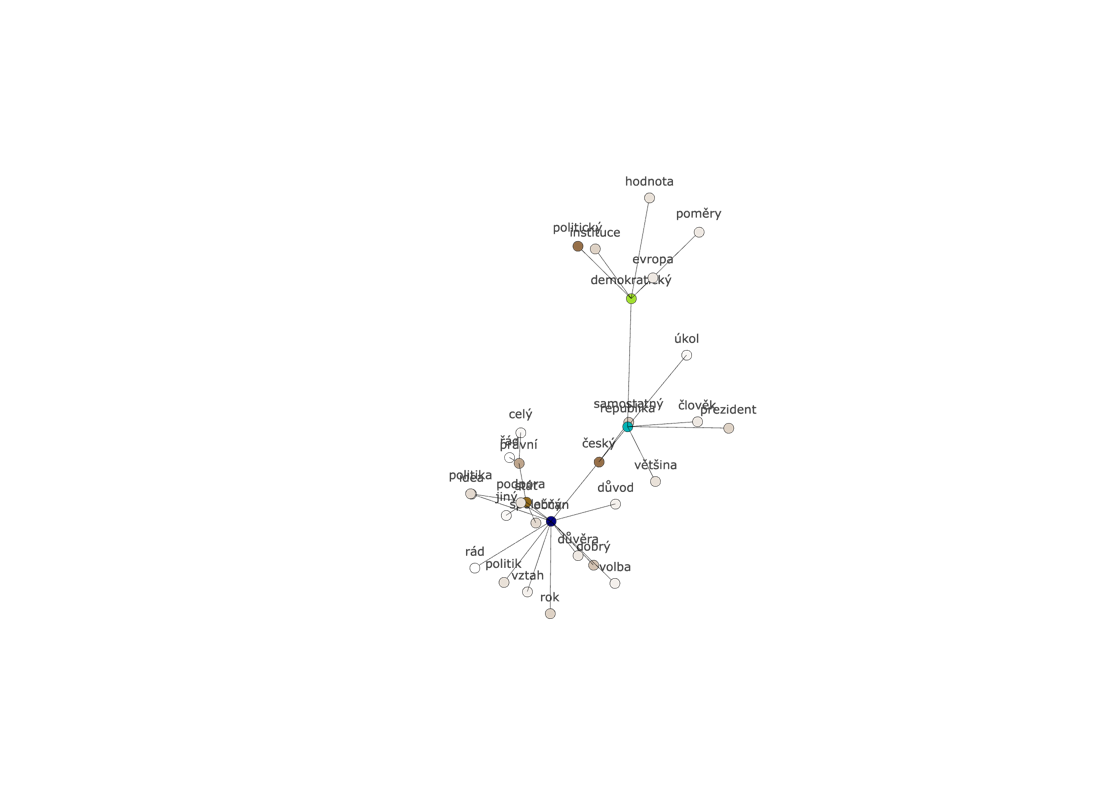

In [34]:
ego_network_standard("Havel", "republika")

# Example of network generation and drawing

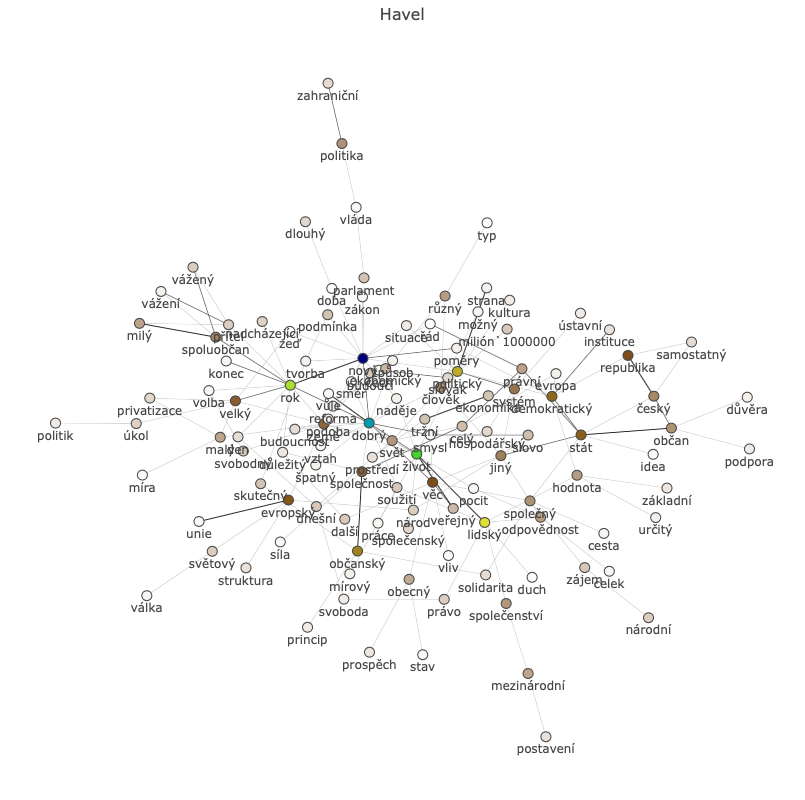

In [62]:
### based on our functions defined externally
### build a network from all speeches by Havel
network_havel = nf.network_formation_df(projevy_df, "Havel", 200, 3)
nf.draw_2d_network(network_havel, "Havel", "offline")

# All presidents

In [63]:
###list of president names
president_names = ["Benes", "Gottwald", "Zapotocky", "Novotny", "Svoboda", "Husak", "Havel", "Klaus", "Zeman"]
### shorter list
president_names_2 = ["Benes", "Gottwald", "Husak", "Havel", "Klaus", "Zeman"]

def generate_and_draw_network(name):
    network = nf.network_formation_df(projevy_df, name, 200, 2)
    return nf.draw_3d_network(network, name, "offline")

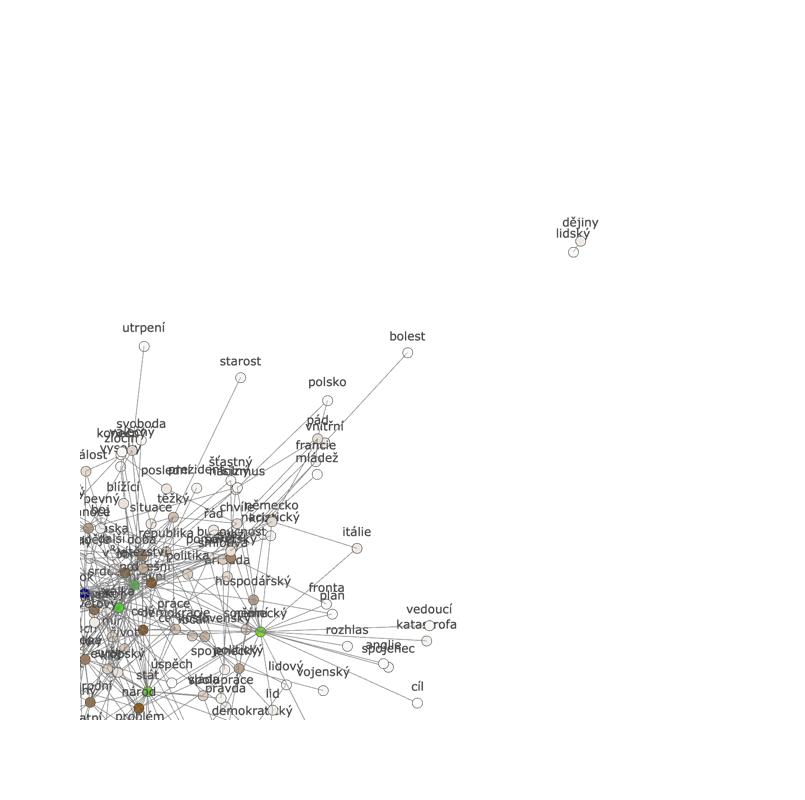

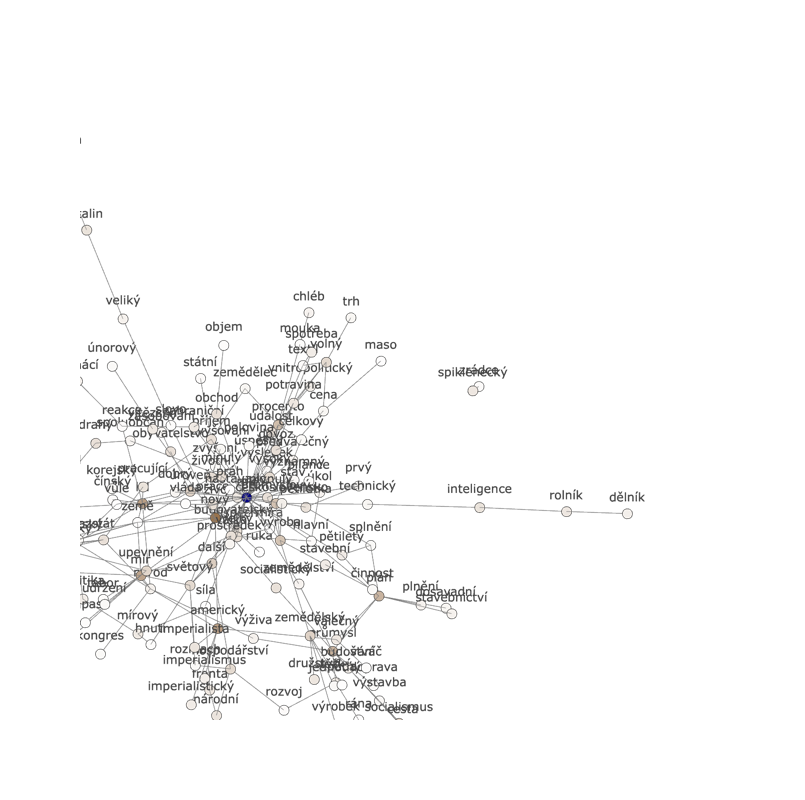

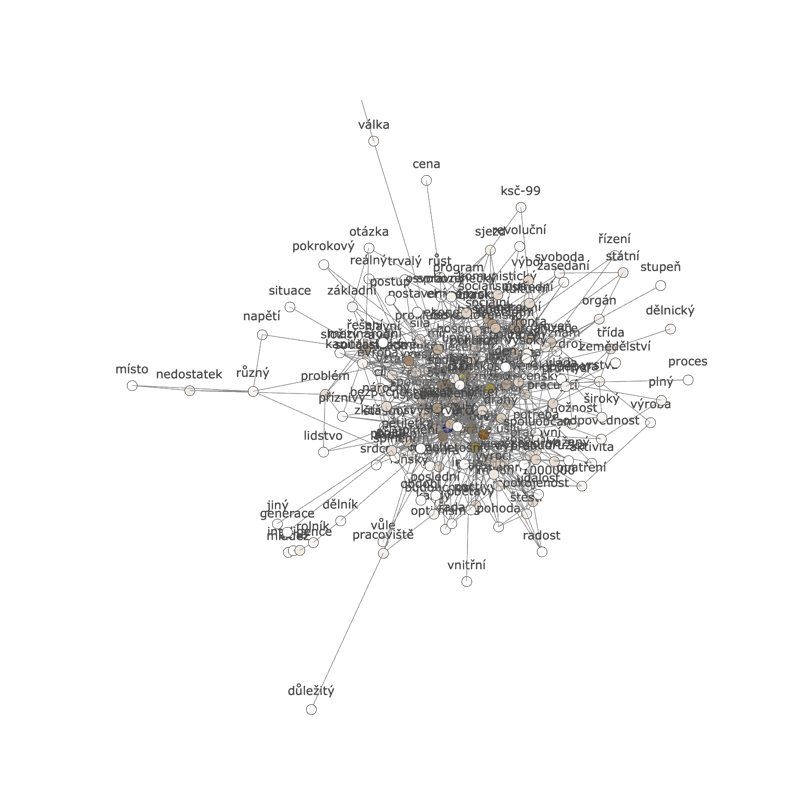

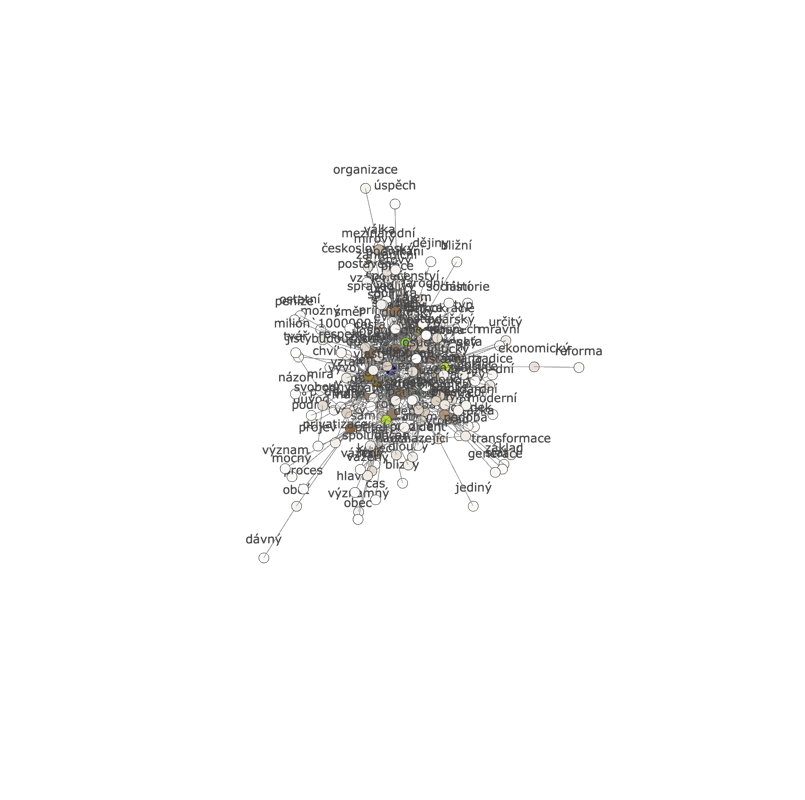

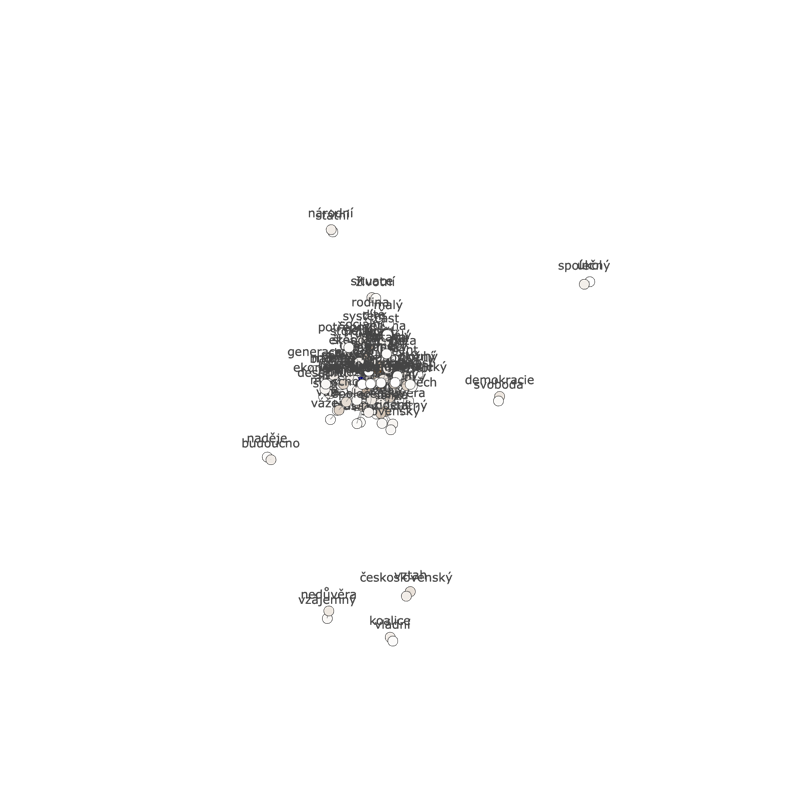

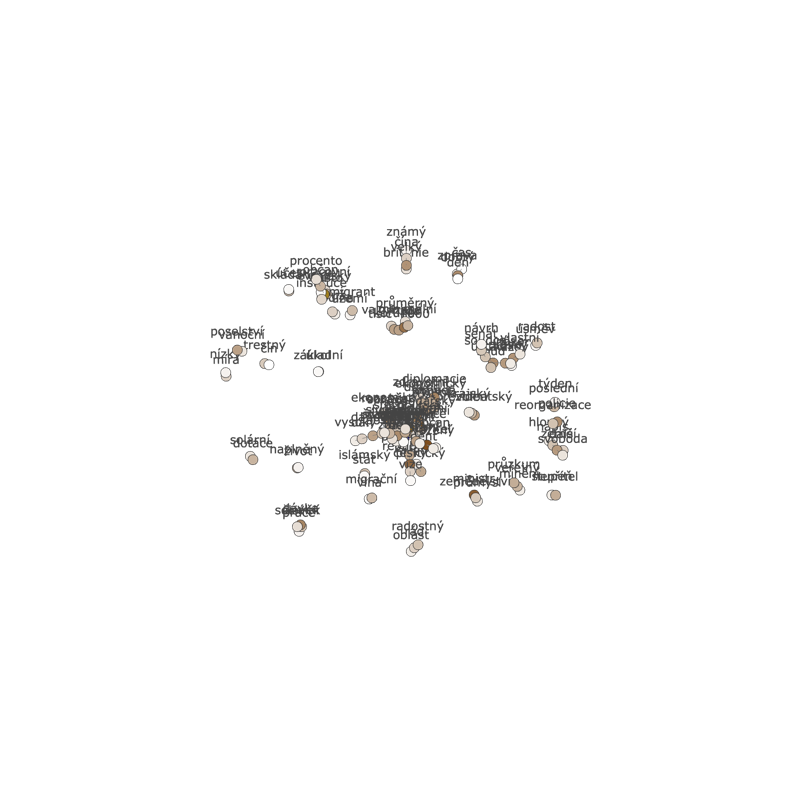

In [64]:
for name in president_names_2:
    generate_and_draw_network(name)

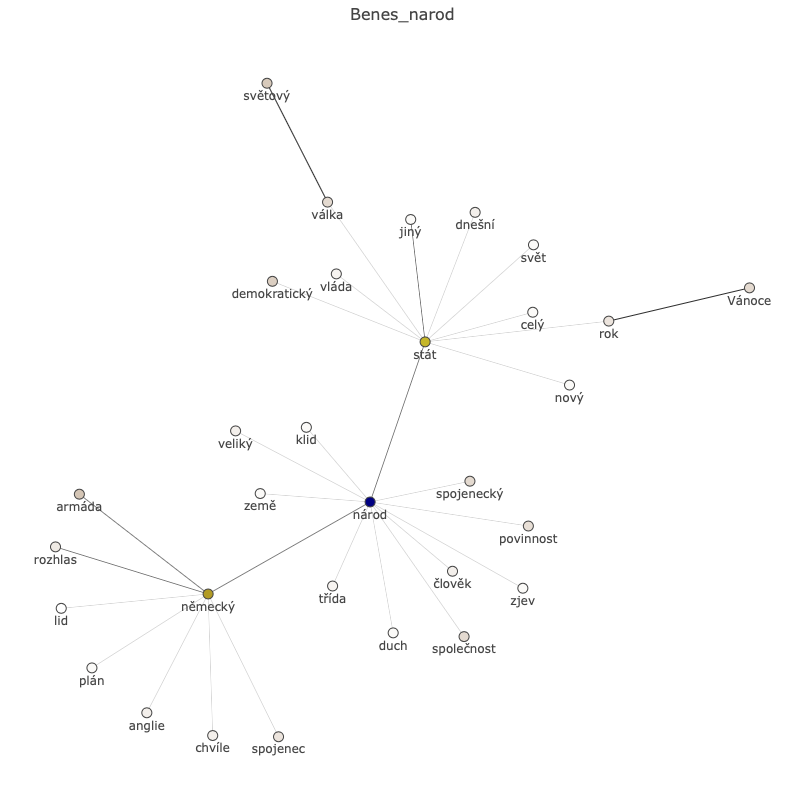

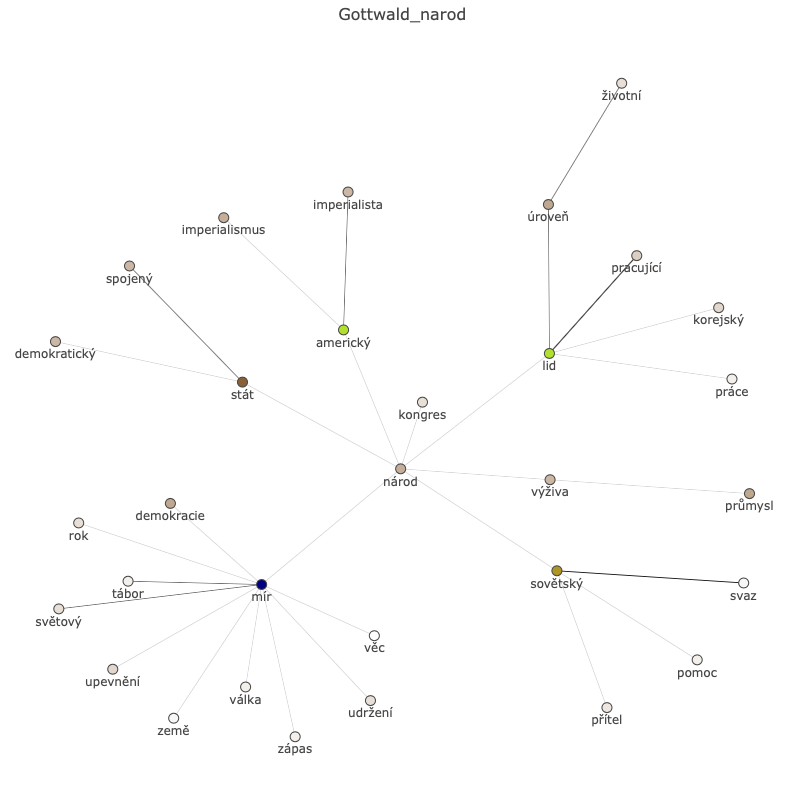

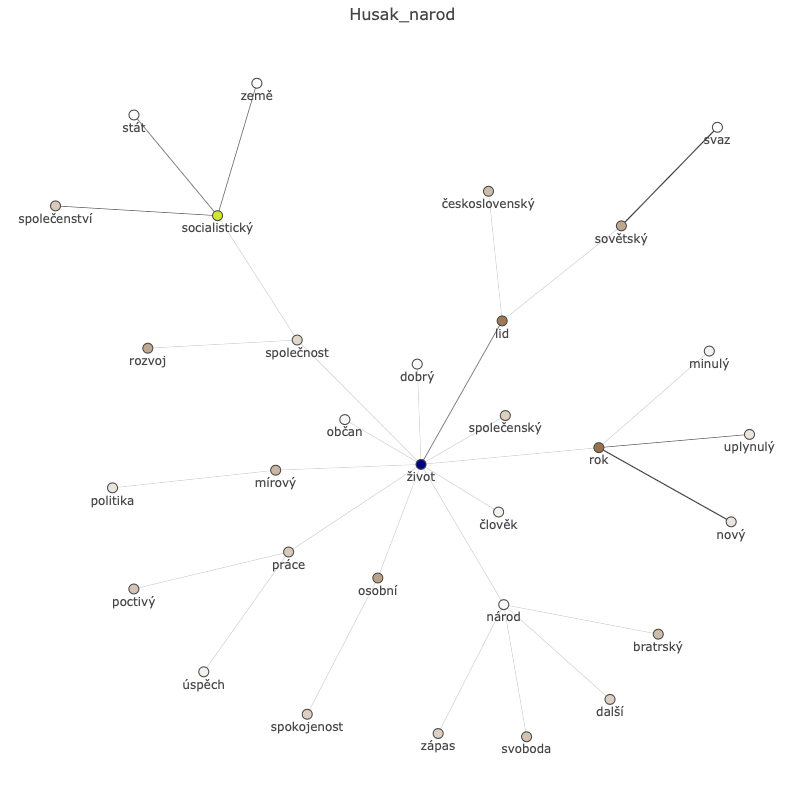

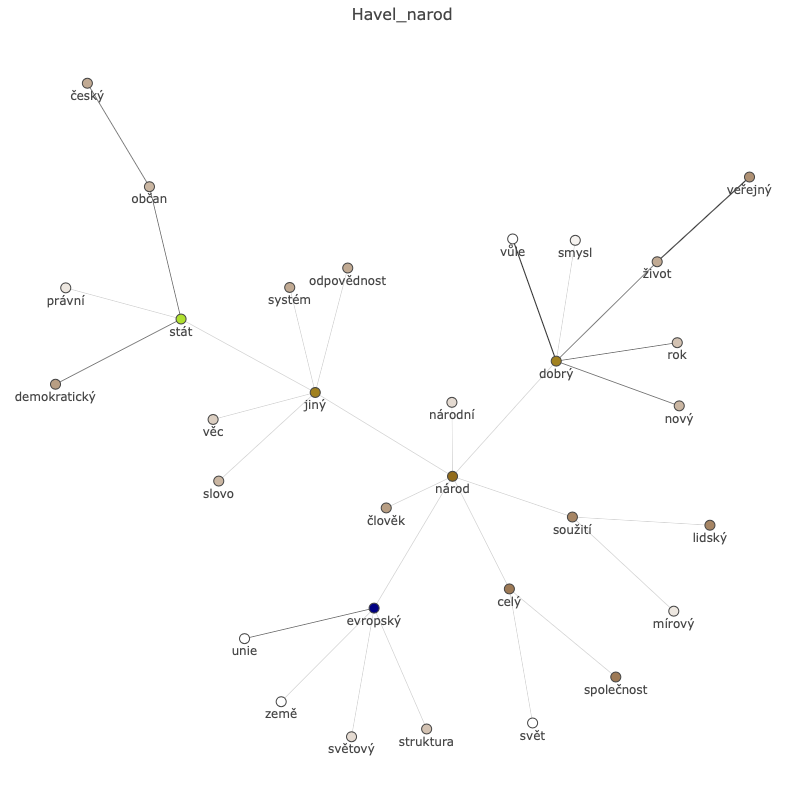

In [21]:
### generate and draw ego networks
president_names_3 = ["Benes", "Gottwald", "Husak", "Havel"]
for name in president_names_3:
    network = nf.network_formation_df(projevy_df, name, 200, 2)
    if "národ" in list(network.nodes):
        nf.ego_network_drawing_reduced(network, "národ", 30, name + "_narod", "offline")

In [22]:
### generate networks and count their mean betweenness
def generate_network_and_count(name):
    network = nf.network_formation_df(projevy_df, name, 200, 2)
    return [network, nx.betweenness_centrality(network, weight="distance")] ## weight="norm_weight")]
networks_and_betweenness = []
for name in president_names:
    networks_and_betweenness.append(generate_network_and_count(name))

In [23]:
len_and_norm_freq = []
for name in president_names:
    lemmata_list = []
    for element in projevy_df[projevy_df["rok_prezident"].str.endswith(name)]["text"].tolist():
        lemmatized_df = lemmatization_and_postagging(element)
        lemmata_list.extend(lemmatized_df[lemmatized_df["TAG"].str.startswith(("N","A"))]["lemma"].tolist())
    lemmata_list.count("národ")
    len_and_norm_freq.append([len(lemmata_list), lemmata_list.count("národ") / len(lemmata_list), lemmata_list.count("republika") / len(lemmata_list)])

In [24]:
name_and_mean_betweenness = []
counter = 0
for element in networks_and_betweenness:
    if "národ" in list(element[1].keys()):
        narod = element[1]["národ"] / np.mean(list(element[1].values()))
    else:
        narod = 0
    if "republika" in list(element[1].keys()):
        republika = element[1]["republika"] / np.mean(list(element[1].values()))
    else:
        republika = 0
    name_and_mean_betweenness.append([president_names[counter], len_and_norm_freq[counter][0], len_and_norm_freq[counter][1], len_and_norm_freq[counter][2], narod, republika])
    counter = counter + 1

In [25]:
name_and_mean_betweenness_df = pd.DataFrame(name_and_mean_betweenness)
name_and_mean_betweenness_df.columns = ["name", "word_count", "narod_freq", "republika_freq", "narod_between", "republika_between"]
name_and_mean_betweenness_df

name  word_count  narod_freq  republika_freq  narod_between  \
0      Benes        7565    0.007799        0.004098       4.569249   
1   Gottwald        4202    0.006901        0.003094       2.002560   
2  Zapotocky        4723    0.005505        0.011010       1.666129   
3    Novotny       11363    0.004928        0.008800       1.376663   
4    Svoboda        3099    0.007422        0.007422       0.774820   
5      Husak       10142    0.004437        0.001775       0.048712   
6      Havel       10269    0.003603        0.004187       0.764978   
7      Klaus        4015    0.000498        0.007472       0.000000   
8      Zeman        1547    0.000646        0.009050       0.000000   

   republika_between  
0           1.394482  
1           0.063844  
2           4.659514  
3           5.248529  
4           0.657527  
5           0.000000  
6           0.444971  
7           1.065649  
8           2.628571

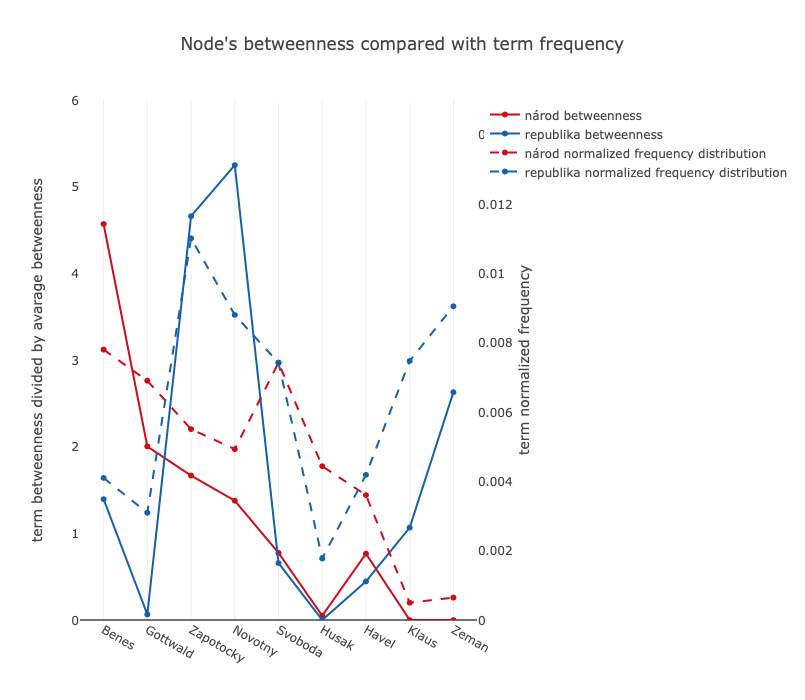

In [27]:
trace1 = go.Scatter(
        x=name_and_mean_betweenness_df['name'], # assign x as the dataframe column 'x'
        y=name_and_mean_betweenness_df['narod_between'],
        yaxis="y1",
        name="národ betweenness",
        mode = "lines+markers",
        line = dict(
            color = ('rgb(205, 12, 24)'),
            width = 2)
        )
trace2 = go.Scatter(
        x=name_and_mean_betweenness_df['name'], # assign x as the dataframe column 'x'
        y=name_and_mean_betweenness_df['republika_between'],
        yaxis="y1",
        name="republika betweenness",
        mode = "lines+markers",
        line = dict(
            color = ('rgb(22, 96, 167)'),
            width = 2)
        )
trace3 = go.Scatter(
        x=name_and_mean_betweenness_df['name'], # assign x as the dataframe column 'x'
        y=name_and_mean_betweenness_df['narod_freq'],
        yaxis="y2",
        name="národ normalized frequency distribution",
        mode = "lines+markers",
        line = dict(
            color = ('rgb(205, 12, 24)'),
            width = 2,
            dash = 'dash')
        )
trace4 = go.Scatter(
        x=name_and_mean_betweenness_df['name'], # assign x as the dataframe column 'x'
        y=name_and_mean_betweenness_df['republika_freq'],
        yaxis="y2",
        name="republika normalized frequency distribution",
        mode = "lines+markers",
        line = dict(
            color = ('rgb(22, 96, 167)'),
            width = 2,
            dash = 'dash')
        )

data = [trace1,trace2,trace3,trace4]

layout = go.Layout(
    autosize=False,
    width=1200,
    height=700,
    title="Node's betweenness compared with term frequency",
    xaxis=dict(showgrid=True, dtick=1),
    yaxis1=dict(showgrid=False, range=[0,6], title='term betweenness divided by avarage betweenness'),
    yaxis2=dict(showgrid=False, range=[0,0.015], title='term normalized frequency', overlaying="y", side="right"),
    )

fig= go.Figure(data=data, layout=layout)
iplot(fig, "../betweenness.html")
###pio.write_image(fig, "../images/betweenness.eps", scale=1)